In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import classification_report,confusion_matrix, accuracy_score, f1_score, precision_score, recall_score, PrecisionRecallDisplay, roc_curve, auc
from sklearn.calibration import calibration_curve, CalibrationDisplay
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LinearRegression
from sklearn.neural_network import MLPClassifier
from sklearn.svm import LinearSVC
from sklearn.impute import SimpleImputer
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.model_selection import cross_validate, GridSearchCV
from sklearn.feature_selection import SelectFromModel, RFE,RFECV
from sklearn.pipeline import Pipeline
import os
import other_ml_models
from comet_ml import Experiment
from comet_ml.integration.sklearn import log_model
from feature_engineering import FeatureEngineering
%matplotlib inline

In [3]:
pd.set_option('display.max_columns', 500)

In [5]:
df_train, df_test = FeatureEngineering("data/all_game_data_milesstone_2.csv").train_test_split()

Split into Train and Validation sets

In [6]:
train_cols = ['x_coordinate', 'y_coordinate', 'last_x_coordinate',
       'last_y_coordinate', 'distance_from_last_event',
       'rebound', 'speed', 'time_since_powerplay_started',
       'num_friendly_non_goalie_skaters', 'num_opposing_non_goalie_skaters',
       'is_emptyNet', 'shot_type', 'shot_distance_to_goal',
       'shot_angle', 'change_in_shot_angle']

X = df_train[train_cols]
y = df_train["is_goal"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, shuffle=True, random_state=42)

# MLP

## Create Pipeline

In [7]:
experiment = Experiment(
  api_key=os.environ.get("COMET_API_KEY"),
  project_name="nhl-data-science",
  workspace="mahmoodhegazy"
)

[experiment.log_dataset_hash(data_set) for data_set in [X_train, X_test, y_train, y_test]]

COMET WARNING: To get all data logged automatically, import comet_ml before the following modules: sklearn.
COMET WARNING: As you are running in a Jupyter environment, you will need to call `experiment.end()` when finished to ensure all metrics and code are logged before exiting.
COMET INFO: Experiment is live on comet.com https://www.comet.com/mahmoodhegazy/nhl-data-science/713fc623dc8d4c5eb8e54a503cb0638c



[None, None, None, None]

In [10]:
mlp_clf=MLPClassifier(hidden_layer_sizes='hidden_layer_sizes', activation = 'activation',solver='solver', alpha='alpha',learning_rate='learning_rate', early_stopping=True, n_iter_no_change=10, random_state=42)
feature_selection_svc= SelectFromModel(estimator=LinearSVC(C=0.1, dual="auto"))
mlp_pipe = other_ml_models.create_pipeline(classifier=mlp_clf,feature_selection=feature_selection_svc)

In [13]:
mlp_pipe

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('Numerical_transform',
                                                  Pipeline(steps=[('Impt',
                                                                   SimpleImputer()),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x2a7ba9250>),
                                                 ('Categorical_transform',
                                                  Pipeline(steps=[('Impt',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('encoder',
                                                                   OrdinalEncod...
                                                                                  unknown_value=-1))]),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x2b881c1d0>)])),
                ('feature_select',
                 SelectFromModel(estimator=LinearSVC(C=0.1, dual='auto'))),
                ('classifier',
                 MLPClassifier(activation='activation', alpha='alpha',
                               early_stopping=True,
                               hidden_layer_sizes='hidden_layer_sizes',
                               learning_rate='learning_rate', random_state=42,
                               solver='solver'))])

## Grid Search Hyperparamtuning

In [20]:
param_grid = {
    'classifier__hidden_layer_sizes': [ (50,50), (10,100,10),(20,20,20), (10, 100, 50, 10), (50, 100, 100, 50)],
    'classifier__activation': ['tanh', 'relu'],
    'classifier__solver': ['sgd', 'adam'],
    'classifier__alpha': [0.01,0.001,0.0001],
    'classifier__learning_rate': ['constant','adaptive'],
}

# Fit a 3-fold GridSearchCV
mlp_gs = GridSearchCV(mlp_pipe, param_grid, cv=3, verbose=1, n_jobs=-1)
mlp_gs.fit(X_train, y_train)

# Print the best parameters and the corresponding score
print("Best parameters:")
print(mlp_gs.best_params_)
print("Grid scores:")
means = mlp_gs.cv_results_['mean_test_score']
stds = mlp_gs.cv_results_['std_test_score']
for mean, std, params in zip(means, stds, mlp_gs.cv_results_['params']):
    print("%0.3f (+/-%0.03f) for %r" % (mean, std * 2, params))

Fitting 3 folds for each of 120 candidates, totalling 360 fits


/Users/mahmoodhegazy/anaconda3/lib/python3.11/site-packages/joblib/externals/loky/process_executor.py:700: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


Best parameters:
{'classifier__activation': 'tanh', 'classifier__alpha': 0.01, 'classifier__hidden_layer_sizes': (50, 100, 100, 50), 'classifier__learning_rate': 'constant', 'classifier__solver': 'adam'}
Grid scores:
0.909 (+/-0.000) for {'classifier__activation': 'tanh', 'classifier__alpha': 0.01, 'classifier__hidden_layer_sizes': (50, 50), 'classifier__learning_rate': 'constant', 'classifier__solver': 'sgd'}
0.909 (+/-0.000) for {'classifier__activation': 'tanh', 'classifier__alpha': 0.01, 'classifier__hidden_layer_sizes': (50, 50), 'classifier__learning_rate': 'constant', 'classifier__solver': 'adam'}
0.909 (+/-0.000) for {'classifier__activation': 'tanh', 'classifier__alpha': 0.01, 'classifier__hidden_layer_sizes': (50, 50), 'classifier__learning_rate': 'adaptive', 'classifier__solver': 'sgd'}
0.909 (+/-0.000) for {'classifier__activation': 'tanh', 'classifier__alpha': 0.01, 'classifier__hidden_layer_sizes': (50, 50), 'classifier__learning_rate': 'adaptive', 'classifier__solver': '

Train on best Hyperparams

In [21]:
mlp_pipe_best = mlp_gs.best_estimator_
mlp_pipe_best.fit(X_train,y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('Numerical_transform',
                                                  Pipeline(steps=[('Impt',
                                                                   SimpleImputer()),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x3188c8190>),
                                                 ('Categorical_transform',
                                                  Pipeline(steps=[('Impt',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('encoder',
                                                                   OrdinalEncoder(handle_unknown='use_encoded_value',
                                                                                  unknown_value=-1))]),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x1735e0410>)])),
                ('feature_select',
                 SelectFromModel(estimator=LinearSVC(C=0.1, dual='auto'))),
                ('classifier',
                 MLPClassifier(activation='tanh', alpha=0.01,
                               early_stopping=True,
                               hidden_layer_sizes=(50, 100, 100, 50),
                               random_state=42))])

## Logging Validation Scores

In [22]:
mlp_preds = mlp_pipe_best.predict(X_test)
mlp_preds_train = mlp_pipe_best.predict(X_train)

print("Accuracy (train): ", accuracy_score(y_train,mlp_preds_train))
print("Accuracy (test): ", accuracy_score(y_test,mlp_preds))
print("Classification report:\n", classification_report(y_test,mlp_preds))

Accuracy (train):  0.9093973695160942
Accuracy (test):  0.9128373680551166
Classification report:
               precision    recall  f1-score   support

           0       0.91      1.00      0.95     43126
           1       1.00      0.05      0.09      4337

    accuracy                           0.91     47463
   macro avg       0.96      0.52      0.52     47463
weighted avg       0.92      0.91      0.88     47463



In [23]:
mlp_preds_prob = mlp_pipe_best.predict_proba(X_test)

{'web': 'https://www.comet.com/api/image/download?imageId=bde26eddcb9544b093cc3af99d2227e0&experimentKey=713fc623dc8d4c5eb8e54a503cb0638c',
 'api': 'https://www.comet.com/api/rest/v1/image/get-image?imageId=bde26eddcb9544b093cc3af99d2227e0&experimentKey=713fc623dc8d4c5eb8e54a503cb0638c',
 'imageId': 'bde26eddcb9544b093cc3af99d2227e0'}

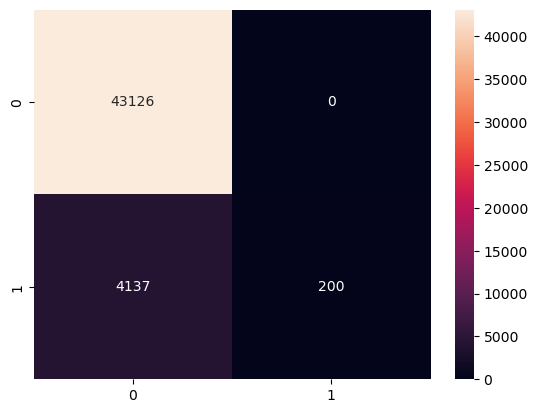

In [24]:
cm=confusion_matrix(y_test, mlp_preds)
sns.heatmap(cm, annot=True,fmt="d")
experiment.log_figure(figure_name='Confusion Matrix', step=None)

In [26]:
metrics = {"accuracy": accuracy_score(y_test, mlp_preds), "f1": f1_score(y_test, mlp_preds), "recall": recall_score(y_test, mlp_preds), "precision": precision_score(y_test, mlp_preds)}
parameter = {
    "model_type": 'Random Forest',
    "param_grid": str(mlp_pipe_best.get_params()),
}
experiment.log_parameters(parameter)
experiment.log_metrics(metrics)

COMET WARNING: truncated string; too long: '{'memory': None, 'steps': [('preprocessor', ColumnTransformer(transformers=[('Numerical_transform',
                                 Pipeline(steps=[('Impt', SimpleImputer()),
                                                 ('scaler', StandardScaler())]),
                                 <sklearn.compose._column_transformer.make_column_selector object at 0x3188c8190>),
                                ('Categorical_transform',
                                 Pipeline(steps=[('Impt',
                                                  SimpleImputer(strategy='most_frequent')),
                                                 ('encoder',
                                                  OrdinalEncoder(handle_unknown='use_encoded_value',
                                                                 unknown_value=-1))]),
                                 <sklearn.compose._column_transformer.make_column_selector object at 0x1735e0410>)])), ('featu

### Prec-Recall Curve

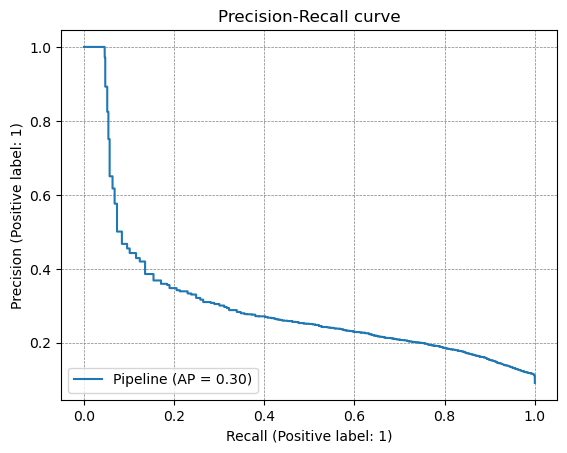

In [27]:
other_ml_models.plot_precision_recall(model=mlp_pipe_best, X_test=X_test, y_test=y_test, experiment=experiment)

### ROC Curve

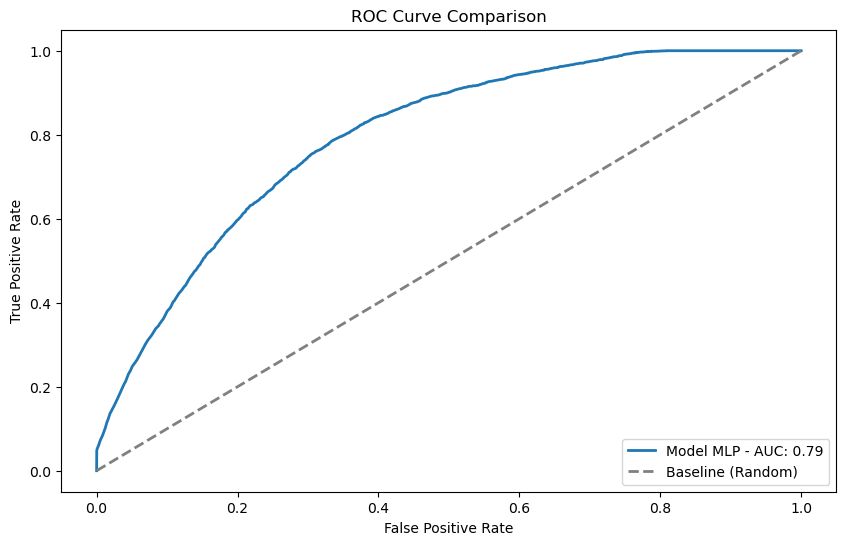

In [28]:
other_ml_models.plot_roc_curve(y_test, mlp_preds_prob, "MLP", experiment)

### Goal Rate Plot

In [156]:
def generate_goal_rate_plot(model_name, binned_data, curr_experiment):
    plt.figure(figsize=(10, 5))
    plt.title("Analysis of Goal Rate by Model")
    sns.lineplot(x='goal_perc_bins', y='goal_rate', data=binned_data, linewidth=2.5, label=model_name)
    plt.xlabel('Model Probability Percentile')
    plt.ylabel('Goal Rate')
    plt.xticks(np.arange(0, 120, 20))
    plt.legend(loc="best")
    curr_experiment.log_figure(figure_name='Goal Rate Plot', step=None)
    plt.show()

In [30]:
bins = list(np.arange(0, 105,  5))
bin_centers = list(np.arange(2.5, 100,  5.0))
df_prob = pd.DataFrame(list(zip(mlp_preds ,y_test ,mlp_preds_prob[:,1]*100)), columns = ['goal_pred', 'goal','goal_probability'])
df_prob['shot'] = 1
sum_goal = df_prob['goal'].sum()
df_prob['percentile'] = df_prob['goal_probability'].rank(pct=True) * 100
df_prob['goal_perc_bins'] = pd.cut(df_prob['percentile'], bins, labels = bin_centers)
df_prob_bined = df_prob[['goal_perc_bins', 'shot', 'goal' ]].groupby(['goal_perc_bins']).sum().reset_index()
df_prob_bined['goal_rate'] = (df_prob_bined['goal']/df_prob_bined['shot'])
df_prob_bined['goal_cum'] = (df_prob_bined['goal']/sum_goal)
df_prob_bined['goal_cumsum'] = 1-df_prob_bined['goal_cum'].cumsum()

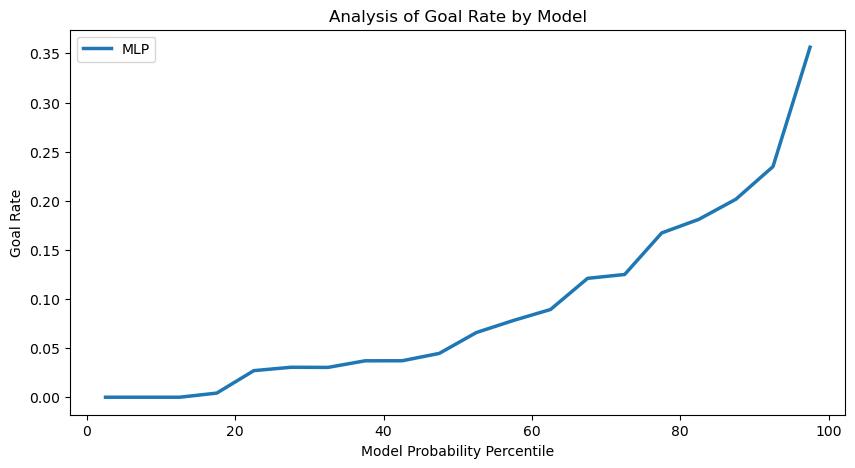

In [32]:
other_ml_models.generate_goal_rate_plot("MLP", df_prob_bined, experiment)

### Cumulative Goal Analysis

In [34]:
def visualize_cumulative_goals(model_name, binned_data, curr_experiment):
    plt.figure(figsize=(10, 5))
    plt.title("Cumulative Goals Analysis")
    sns.lineplot(x='goal_perc_bins', y='goal_cumsum', data=binned_data, linewidth=2.5, label=model_name)
    plt.xlabel('Percentile of Model Predictions')
    plt.ylabel('Cumulative Goal Ratio')
    plt.xticks(np.arange(0, 120, 20))
    plt.legend(loc="lower right")
    curr_experiment.log_figure(figure_name='Cumulative Goal Analysis Plot', step=None)
    plt.show()

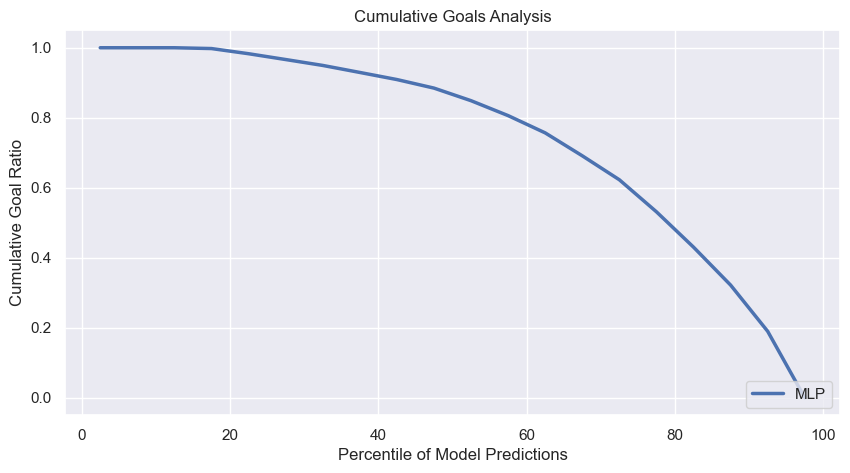

In [35]:
visualize_cumulative_goals("MLP", df_prob_bined, experiment)

### Calibration curve

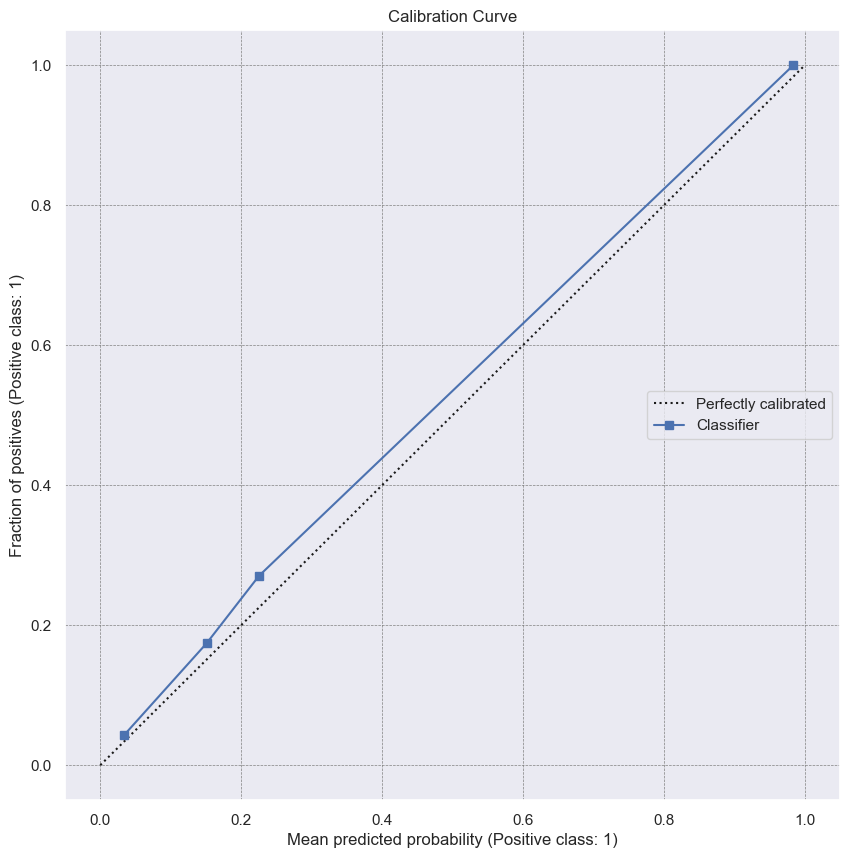

In [36]:
other_ml_models.plot_calibration_curve(y_test, mlp_preds_prob, experiment)

### Save Model

In [37]:
import pickle

In [38]:
if not os.path.exists('models/'):
    os.mkdir('models/')
    
pickle.dump(mlp_pipe_best, open('models/MLP.sav', 'wb'))
experiment.log_model("MLP Clf", 'models/MLP.sav')

{'web': 'https://www.comet.com/api/asset/download?assetId=6147265a5c0c46e9b3126de980d8794f&experimentKey=713fc623dc8d4c5eb8e54a503cb0638c',
 'api': 'https://www.comet.com/api/rest/v2/experiment/asset/get-asset?assetId=6147265a5c0c46e9b3126de980d8794f&experimentKey=713fc623dc8d4c5eb8e54a503cb0638c',
 'assetId': '6147265a5c0c46e9b3126de980d8794f'}

In [39]:
experiment.end()

COMET INFO: ---------------------------------------------------------------------------------------
COMET INFO: Comet.ml Experiment Summary
COMET INFO: ---------------------------------------------------------------------------------------
COMET INFO:   Data:
COMET INFO:     display_summary_level : 1
COMET INFO:     url                   : https://www.comet.com/mahmoodhegazy/nhl-data-science/713fc623dc8d4c5eb8e54a503cb0638c
COMET INFO:   Metrics:
COMET INFO:     accuracy  : 0.9128373680551166
COMET INFO:     f1        : 0.08816398501212254
COMET INFO:     precision : 1.0
COMET INFO:     recall    : 0.04611482591653217
COMET INFO:   Parameters:
COMET INFO:     model_type : Random Forest
COMET INFO:     param_grid : {'memory': None, 'steps': [('preprocessor', ColumnTransformer(transformers=[('Numerical_transform',
                                 Pipeline(steps=[('Impt', SimpleImputer()),
                                                 ('scaler', StandardScaler())]),
                   